In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


Trial 5 Complete [00h 06m 39s]
val_accuracy: 0.9735999703407288

Best val_accuracy So Far: 0.9784799814224243
Total elapsed time: 00h 40m 35s
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1368/1368 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9765 - loss: 0.0874 - val_accuracy: 0.9786 - val_loss: 0.0816
Epoch 2/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.9770 - loss: 0.0861 - val_accuracy: 0.9795 - val_loss: 0.0803
Epoch 3/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.9785 - loss: 0.0816 - val_accuracy: 0.9790 - val_loss: 0.0820
Epoch 4/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.9792 - loss: 0.0793 - val_accuracy: 0.9806 - val_loss: 0.0770
Epoch 5/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.9795 - loss: 0.0796 - val_accuracy: 0.9799 - val_loss: 0.0772
Epoch 6/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.9791 - loss: 0.0788 - val_accuracy: 0.9804 - val_loss: 0.0754
Epoch 7/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.9803 - loss: 0.0759 - val_accuracy: 0.9814 - val_loss: 0.0755
Epoch 8/20
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 83s 33ms/step - accuracy: 0.9813 - loss: 0.07

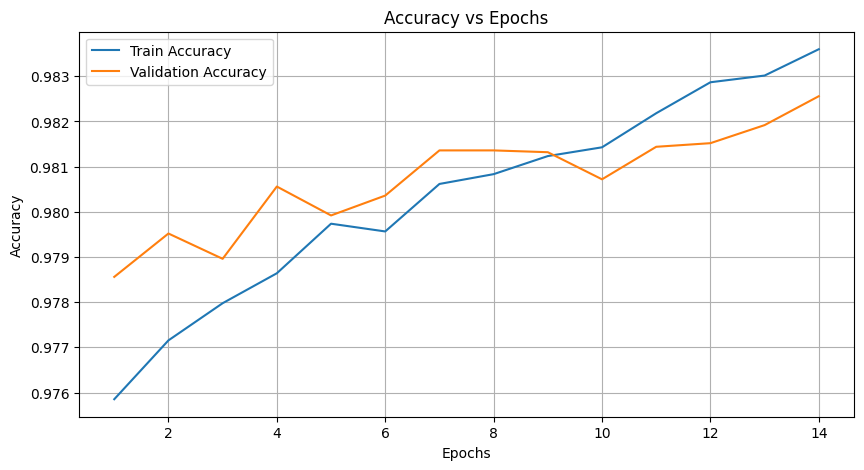

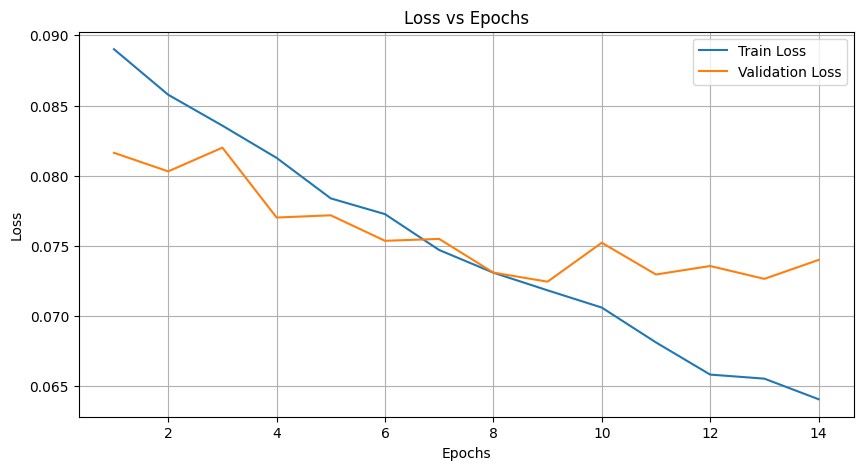

Final Test Accuracy: 0.9806
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.9689    0.9978    0.9831      7591
           1     0.9964    0.9505    0.9729      4909

    accuracy                         0.9792     12500
   macro avg     0.9826    0.9741    0.9780     12500
weighted avg     0.9797    0.9792    0.9791     12500



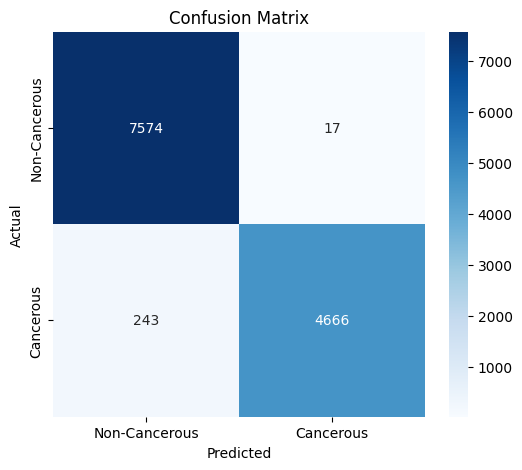

In [2]:
# Install required packages if needed:
# pip install pandas numpy scikit-learn imbalanced-learn keras-tuner matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from kerastuner.tuners import RandomSearch
import tensorflow as tf

# ========== 1. Load and Prepare Data with K-mer Encoding ==========
df = pd.read_csv("/content/Final.csv")  # Assumes 'sequence' and 'label' columns
X = df['sequence']
y = df['label']

# ----- K-mer encoding -----
def get_kmers(sequence, k=4):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

k = 3

# Build k-mer vocabulary
all_kmers = set()
for seq in X:
    all_kmers.update(get_kmers(seq, k))
kmer2idx = {kmer: idx + 1 for idx, kmer in enumerate(sorted(all_kmers))}  # 0 reserved for padding

# Encode sequences
X_kmer_encoded = [[kmer2idx[kmer] for kmer in get_kmers(seq, k)] for seq in X]
maxlen = max(len(seq) for seq in X_kmer_encoded)
X_padded = pad_sequences(X_kmer_encoded, maxlen=maxlen, padding='post')

# ========== 2. Balance Dataset using SMOTE ==========

smote = SMOTE(sampling_strategy={1: 50000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_padded, y)


# ========== 3. Split into Train, Validation, Test ==========
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# ========== 4. Callback to Track Test Accuracy and Loss ==========
class TestPerformance(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_acc.append(acc)

test_callback = TestPerformance((X_test, y_test))
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# ========== 5. Keras Tuner Hyperparameter Model ==========
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(kmer2idx)+1,  # +1 for padding
                        output_dim=hp.Choice('embedding_dim', [8, 16, 32]),
                        input_length=maxlen))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', 32, 128, step=32), return_sequences=False)))
    model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ========== 6. Tuning ==========
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='bi_lstm_kmer_gene'
)

tuner.search(X_train, y_train,
             epochs=10,
             batch_size=64,
             validation_data=(X_val, y_val),
             callbacks=[early_stop])

# ========== 7. Get Best Model ==========
best_model = tuner.get_best_models(num_models=1)[0]

# ========== 8. Train with Test Callback ==========
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, test_callback]
)

# ========== 9. Plot Accuracy and Loss ==========
epochs = range(1, len(history.history['accuracy']) + 1)

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Test Accuracy: {test_callback.test_acc[-1]:.4f}")

# ========== 10. Confusion Matrix and Classification Report ==========
y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

conf_mat = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("Classification Report:\n", report)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancerous', 'Cancerous'], yticklabels=['Non-Cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
